# Calculate Insertion Coordinates

**Purpose:** Given a set of probes each moving along a unique set of local axes, how do we align them with targets in a global coordinate space?

**Prerequisites:** 
1. A calibration file (`calibration_info.py`) with the measured global and local coordinates at each calibration point
2. A set of targets (in global coordinate space) for each probe


In [1]:
#RUN the code
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import rotations # local Python file
import calibration_info # local Python file

### Step 1: Find the relative rotation and offset of each probe to the global coordinate space

In [2]:
#RUN the code

# import the global and local coordinates of our calibration poitns
calibrationInfo = calibration_info.getCalibrationInfo()

# create a dictionary to store the results
results = { }

# use least-squares optimization to find the best fit translational offset and rotation matrix
for probe_name in calibrationInfo.keys():
    offset, R = \
        rotations.fit_params(calibrationInfo[probe_name]['global_coords'], 
                             calibrationInfo[probe_name]['local_coords'])
    results[probe_name] = {'offset' : offset, 'rotation' : R}

### Step 2: Input the X Y Z target coordinates (in global coordinate space) for each probe

The Z coordinate is the distance of the target below (negative values) or above (positive values) the calibration reticle.

In [3]:
#ENTER your values here

targets = { }

targets['probeA'] = [-2,0,0]
targets['probeB'] = [-1,1.5,0]
targets['probeC'] = [0,2,0]
targets['probeD'] = [1.5,1.5,0]
targets['probeE'] = [2,0,0]
targets['probeF'] = [1,-1,0]

manipulator_range = 6 # <--- change this number of match the full travel range (in mm) of your manipulator

### Step 3: Transform the global targets to each probe's local coordinate space

To hit these coordinates, drive the probe to the X/Y location, and then insert along the Z axis

In [4]:
#RUN the code

#Define helper functions
def global_to_manipulator(global_coordinate, probe_results):
    coords = np.array(global_coordinate).T
    manipulator_coords = np.dot(coords + probe_results['offset'], probe_results['rotation'])
    return manipulator_coords

def print_targets(targets):
    for probe_name, target in targets.items():
        print(probe_name + ' insertion coordinates:')
        print(targets[probe_name])
        print(' ')

def manipulator_to_global(manipulator_coordinanates, probe_result):
    invRotMat = np.linalg.inv(probe_result['rotation'])
    coords = manipulator_coordinanates.T
    global_coords = np.dot(manipulator_coordinanates, invRotMat) - probe_result['offset']
    return global_coords
    
def plot_circle(radius, style='--k', z=0):
    angles = np.linspace(0,2*np.pi,30)
    xp = radius * np.cos(angles);
    yp = radius * np.sin(angles);
    zp = np.ones(angles.size)*z
    plt.plot(xp,yp,zp,style)

def plot_coverslip():
    plot_circle(3.5)
    plot_circle(2.5,'-c')
    plot_circle(2.5,'-c', z=-.150)
    plot_circle(2.5,'-c', z=-.300)
    plot_circle(2.5,'-c', z=-.450)
    plt.plot([-2.5,2.5],[0,0],'-c')
    plt.plot([0,0],[-2.5,2.5],'-c')
    
def plot_cube(probe_result, color):
    corners = (np.array([[1,1,1],
                        [1,-1,1],
                        [-1,-1,1],
                        [-1,1,1],
                        [1,1,1],
                        [1,1,-1],
                        [1,-1,-1],
                        [-1,-1,-1],
                        [-1,1,-1],
                        [1,1,-1],
                        [1,1,-1],
                        [1,-1,-1],
                        [1,-1,1],
                        [-1,-1,1],
                        [-1,-1,-1],
                        [-1,-1,1],
                        [-1,1,1],
                        [-1,1,-1]]))*(manipulator_range / 2)
    
    for c in range(corners.shape[0]-1):
        
        pt1a = manipulator_to_global(corners[c,:], probe_result)
        pt2a = manipulator_to_global(corners[c+1,:], probe_result)
    
        plt.plot([pt1a[0],pt2a[0]], [pt1a[1],pt2a[1]], [pt1a[2],pt2a[2]],color=color)

def get_new_probe_subplot(probe_idx, results):

    subplot_num = int('1'+str(len(results.keys()))+'1')+probe_idx
    ax = fig.add_subplot(subplot_num, projection='3d')
    
    plot_coverslip()
    return ax

def global_vect_to_local_vect(global_vector, probe_results):
    coords = np.array(global_vector).T
    coords = np.dot(coords, probe_results['rotation'])
    return coords

def get_starting_coords(manipulator_coords):
    manipulator_starting_coords = manipulator_coords.copy()
    manipulator_starting_coords[2]=manipulator_range
    return manipulator_starting_coords

def plot_line_in_global(probe_name, manipulator_coords1, manipulator_coords2, color='b', marker1=None, marker2=None):
    global_coords1 = manipulator_to_global(manipulator_coords1, results[probe_name])
    global_coords2 = manipulator_to_global(manipulator_coords2, results[probe_name])
    if marker1:
        plt.plot(np.array([global_coords1[0]]),
             np.array([global_coords1[1]]),
             np.array([global_coords1[2]]),marker=marker1, markersize=7, color=color)
    if marker2:
        plt.plot(np.array([global_coords2[0]]),
             np.array([global_coords2[1]]),
             np.array([global_coords2[2]]),marker=marker2, markersize=7, color=color)
    
    plt.plot(np.array([global_coords1[0],global_coords2[0]]),
             np.array([global_coords1[1],global_coords2[1]]),
             np.array([global_coords1[2],global_coords2[2]]),color=color)
    
def plot_trajectory(probe_idx, manipulator_coords, color='b', marker1=None):
    manipulator_starting_coords = get_starting_coords(manipulator_coords)
    plot_line_in_global(probe_name, manipulator_coords, manipulator_starting_coords, color=color, marker1=marker1)

def center_view(ax, probe_name, center, scale_factor=1):
    (x,y,z) = manipulator_to_global(center, results[probe_name])
    ax.set_ylim([y-manipulator_range/scale_factor,y+manipulator_range/scale_factor])
    ax.set_xlim([x-manipulator_range/scale_factor,x+manipulator_range/scale_factor])
    ax.set_zlim([z-manipulator_range/scale_factor,z+manipulator_range/scale_factor])  
    
def plot_new_and_old(new_target, old_target, scale_factor=6):
    ax = get_new_probe_subplot(probe_idx, results)

    #plot the trajectory for the new coordinates in GREEN
    plot_trajectory(probe_idx, new_target, color='g', marker1='x')

    #plot the trajectory for the old coordinates in RED
    plot_trajectory(probe_idx, old_target, color='r', marker1='x')

    #Change these to zoom in on the area we adjusted
    center_view(ax, probe_name, new_target, scale_factor)

    plt.title(probe_name, fontsize=15)
    return ax

In [5]:
# RUN the code

# print the target coordinates for each probe

step_3_targets = {}
for probe_name in results.keys():
    step_3_targets[probe_name] = global_to_manipulator(targets[probe_name], results[probe_name])

print_targets(step_3_targets)

probeA insertion coordinates:
[-2.38710205 -0.10494007 -0.05077784]
 
probeB insertion coordinates:
[-1.9123522  -2.34164356  0.09352258]
 
probeC insertion coordinates:
[-0.49761648 -1.93477631 -0.31520506]
 
probeD insertion coordinates:
[ 0.20887829 -0.49048928 -0.31335283]
 
probeE insertion coordinates:
[-0.55825416 -0.06980714 -0.60790407]
 
probeF insertion coordinates:
[-0.53528485  0.98416534 -0.30279381]
 


### Step 4: Visualize the full range of motion for each probe

The target coordinates are shown as the red dots

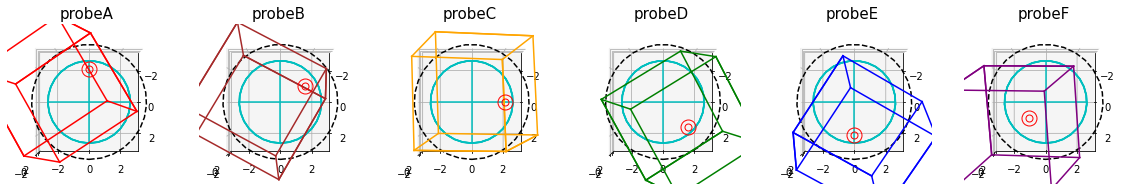

In [6]:
#RUN the code
#Plot the target and the full range of manipulator travel relative to the coverslip
fig = plt.figure(figsize=(20,12))

for probe_idx, (probe_name, manipulator_coords) in enumerate(step_3_targets.items()):
    ax = get_new_probe_subplot(probe_idx, results)
    
    colors = ('red','brown','orange','green','blue','purple')
    color = colors[probe_idx]
    plot_cube(results[probe_name], color)
    
    global_coordinates = manipulator_to_global(manipulator_coords, results[probe_name])
    plt.plot(np.array([global_coordinates[0]]),
             np.array([global_coordinates[1]]),
             np.array([global_coordinates[2]]),'or', markersize=7, markerfacecolor='none')
    plt.plot(np.array([global_coordinates[0]]),
             np.array([global_coordinates[1]]),
             np.array([global_coordinates[2]]),'or', markersize=15, markerfacecolor='none')
    
    ax.set_ylim([-manipulator_range/2,manipulator_range/2])
    ax.set_xlim([-manipulator_range/2,manipulator_range/2])
    ax.set_zlim([-manipulator_range/2,manipulator_range/2])
    plt.gca().invert_zaxis()
    
    ax.view_init(elev=90., azim=0.)
    
    
    plt.title(probe_name, fontsize=15)

### Step 5: Adjust for the thickness of the coverslip

If you follow steps 78-82 in the paper it is necessary to account for the thickness of the coverslip that will be removed. 

Alternately, this step can be used to adjust the computed coordinates from step 3 if you find that targets are constently lower or higher than expected in the global coordinate space. 

In [7]:
#ENTER your values here
#Enter the glass coverslip thickness (in mm)
coverslip_thickness = .475

#Enter the X Y Z target coordinates (in MANIPULATOR coordinate space) for each probe
#Use the output of step 3, or enter your own values from steps 78-82 in the paper
targets = step_3_targets

#targets = { }
#targets['probeA'] = [-2.38710205, -0.10494007, -0.05077785]
#targets['probeB'] = [-1.9123522, -2.34164356,  0.09352259]
#targets['probeC'] = [-0.49761648, -1.93477631, -0.31520506]
#targets['probeD'] = [ 0.20887828, -0.49048928, -0.31335284]
#targets['probeE'] = [-0.55825416, -0.06980714, -0.60790407]
#targets['probeF'] = [-0.53528485,  0.98416534, -0.30279381]


In [8]:
#RUN the code
#adjust each probe for the coverslip thickness
coverslip_vect = [0,0,-coverslip_thickness]

step_5_targets={}
for probe_name in results.keys():
    step_5_targets[probe_name] = targets[probe_name]+global_vect_to_local_vect(coverslip_vect, results[probe_name])

#print new manipulator coordinates
print_targets(step_5_targets)

probeA insertion coordinates:
[-2.49101577  0.02090874 -0.49685969]
 
probeB insertion coordinates:
[-1.9912836  -2.22818852 -0.3609252 ]
 
probeC insertion coordinates:
[-0.59221955 -1.80170741 -0.76126328]
 
probeD insertion coordinates:
[ 0.09569702 -0.37285656 -0.75942182]
 
probeE insertion coordinates:
[-0.67724028  0.04898356 -1.05215184]
 
probeF insertion coordinates:
[-0.65852516  1.13233256 -0.73694045]
 


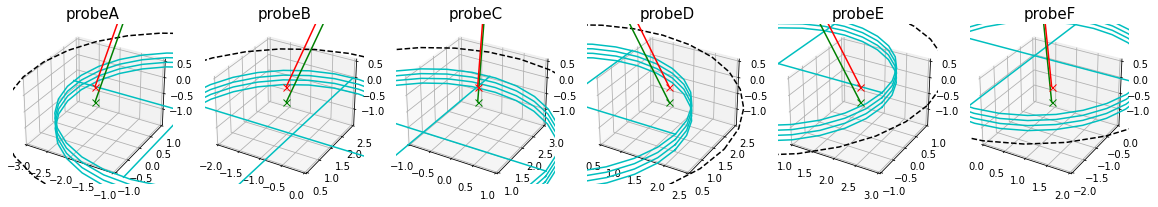

In [9]:
#RUN the code

#plot a top view for all probes with their trajectories in GREEN 
#relative to what was computed for step 3 in RED
    
fig = plt.figure(figsize=(20,12))
for probe_idx, (probe_name, step_5_target) in enumerate(step_5_targets.items()):

    ax = plot_new_and_old(step_5_target, targets[probe_name], scale_factor=6)
    #ax.view_init(elev=90., azim=0.)

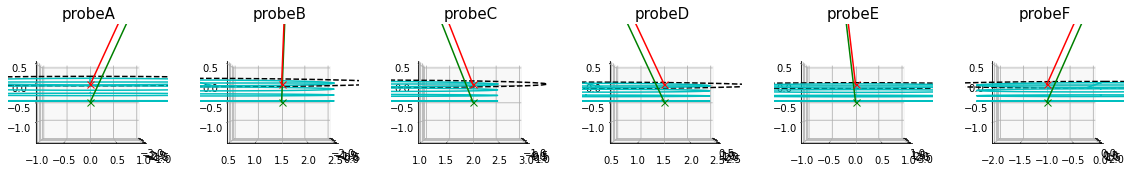

In [10]:
#RUN the code

#plot a side view for each probe with its trajectory from one side (azimuth = 0)
fig = plt.figure(figsize=(20,12))
for probe_idx, (probe_name, step_5_target) in enumerate(step_5_targets.items()):

    ax = plot_new_and_old(step_5_target, targets[probe_name], scale_factor=6)
    ax.view_init(elev=0., azim=0.)

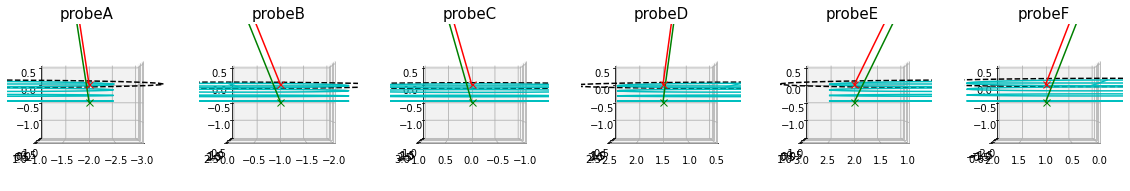

In [11]:
#RUN the code

#plot a side view for each probe with its trajectory from the other side side (azimuth = 90)
fig = plt.figure(figsize=(20,12))
for probe_idx, (probe_name, step_5_target) in enumerate(step_5_targets.items()):

    ax = plot_new_and_old(step_5_target, targets[probe_name], scale_factor=6)
    ax.view_init(elev=0., azim=90.)


### Step 6: Input the information for agarose calibration and other relevant parameters

Steps 75-77 in the paper

Alternately, you can infer these values based on the average error of your inertions, this may be particularly useful for deeper targets

In [12]:
#ENTER your values here

#Enter the offset introduced by the agarose in global coordinates in mm
#values are X and Y, since they should be the bend should be assessed 
#relative to the tip position at the same global Z
#Step 75 in th paper
agarose_offsets = {}
agarose_offsets['probeA'] = [-.2,0]
agarose_offsets['probeB'] = [-.1,.15]
agarose_offsets['probeC'] = [0,.2]
agarose_offsets['probeD'] = [.15,.15]
agarose_offsets['probeE'] = [.2,0]
agarose_offsets['probeF'] = [.1,-.1]

#Enter the calibration agarose thickness (in mm)
#Step 77 in the paper
calibration_agarose_thickness = 1.5

#Enter the window material thickness (in mm)
plastic_window_thickness = .500

#Enter the distance between the bottom surface of the insertion window 
#and the plane of the reticle (plane where global Z = 0) 
bottom_surface_height = 1.5


### Step 7: Generate final coordinates

Input the X Y Z target coordinates (in MANIPULATOR coordinate space) and account for the agarose to generate final target



In [13]:
#ENTER your values here

#Use the output of step 3 or step 5, or enter your own custom values
targets = step_5_targets

#targets = { }
#targets['probeA'] = [-2.38710205, -0.10494007, -0.05077785]
#targets['probeB'] = [-1.9123522, -2.34164356,  0.09352259]
#targets['probeC'] = [-0.49761648, -1.93477631, -0.31520506]
#targets['probeD'] = [ 0.20887828, -0.49048928, -0.31335284]
#targets['probeE'] = [-0.55825416, -0.06980714, -0.60790407]
#targets['probeF'] = [-0.53528485,  0.98416534, -0.30279381]


In [14]:
#RUN the code

#get the offsets in mm offset/mm thickness
scaled_agarose_offsets = {}
for key, coords in agarose_offsets.items():
    scaled_agarose_offsets[key] = np.array(coords)/calibration_agarose_thickness
    
step_7_targets = {}
for probe_idx, (probe_name, target) in enumerate(targets.items()):
#1. compute the thickness of the agarose 
    #convert the target to global coordinates
    global_target_coordinates = manipulator_to_global(target, results[probe_name])
    
    #Take the Z value
    z = global_target_coordinates[2]
    
    #Add the distance to the insertion window and the thickness of the window
    agarose_thickness = z+bottom_surface_height+plastic_window_thickness
    
#2. multiply by the calibrated values to compute the offset in global space
    agarose_offset = scaled_agarose_offsets[probe_name]
    apply_offset = list(agarose_offset*agarose_thickness)
    apply_offset.append(0)
    
#3. apply the offset to the targets
    step_7_targets[probe_name] = target+global_vect_to_local_vect(apply_offset, results[probe_name])

#print the new targets
    print(probe_name + ' insertion coordinates:') 
    print(step_7_targets[probe_name])
    print(' ')

probeA insertion coordinates:
[-2.601017   -0.14865187 -0.51907168]
 
probeB insertion coordinates:
[-2.07688503 -2.38829646 -0.3860291 ]
 
probeC insertion coordinates:
[-0.59925949 -1.99684256 -0.81798327]
 
probeD insertion coordinates:
[ 0.14365652 -0.57285423 -0.82433193]
 
probeE insertion coordinates:
[-0.57991201 -0.11525345 -1.12213653]
 
probeF insertion coordinates:
[-0.56778469  1.0372088  -0.79516295]
 


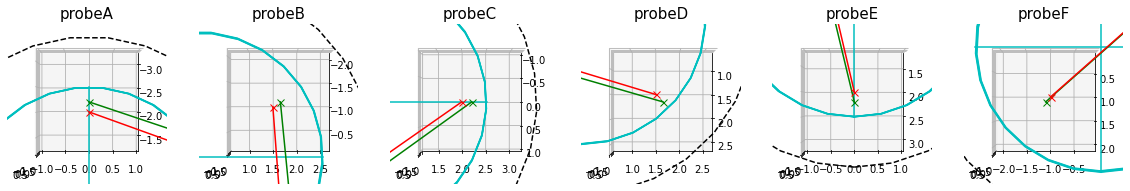

In [15]:
#RUN the code

#plot a top view for all probes with their trajectories
fig = plt.figure(figsize=(20,12))
for probe_idx, (probe_name, step_7_target) in enumerate(step_7_targets.items()):

    ax = plot_new_and_old(step_7_target, targets[probe_name], scale_factor=6)
    ax.view_init(elev=90., azim=0.)

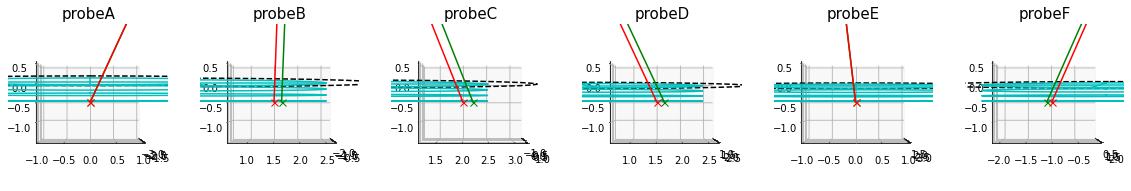

In [16]:
#RUN the code

#plot a side view for each probe with its trajectory from one side (azimuth = 0)
fig = plt.figure(figsize=(20,12))
for probe_idx, (probe_name, step_7_target) in enumerate(step_7_targets.items()):

    ax = plot_new_and_old(step_7_target, targets[probe_name], scale_factor=6)
    ax.view_init(elev=0., azim=0.)



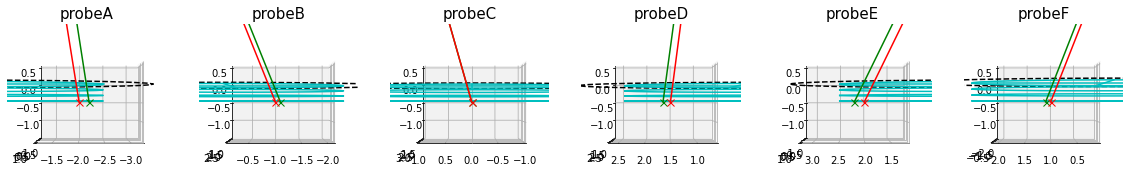

In [17]:
#RUN the code

#plot a side view for each probe with its trajectory from one side (azimuth = 90)
fig = plt.figure(figsize=(20,12))
for probe_idx, (probe_name, step_7_target) in enumerate(step_7_targets.items()):

    ax = plot_new_and_old(step_7_target, targets[probe_name], scale_factor=6)
    ax.view_init(elev=0., azim=90.)

